In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tifffile import imread

import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization,Dropout, Input,Bidirectional, LSTM,Concatenate,GlobalAveragePooling3D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
#from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv
import pywt

from plotly.offline import init_notebook_mode
import scipy.io as sio
import h5py

In [ ]:
pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.2 MB/s eta 0:00:00


In [ ]:
X = np.load("indianpinearray.npy")
y = np.load("IPgt.npy")

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
test_ratio = 0.7
windowSize = 25

In [ ]:
print(X.shape)
print(y.shape)

(145, 145, 200)
(145, 145)


In [ ]:
newX = np.reshape(X, (-1, X.shape[2]))
pca = PCA(n_components=30, whiten=True)
newX = pca.fit_transform(newX)
newX = np.reshape(newX, (X.shape[0],X.shape[1], 30))
X = newX

X.shape

(145, 145, 30)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

In [ ]:
X_train = X_train.reshape(-1, windowSize, windowSize, 30, 1)
X_train.shape

(3074, 25, 25, 30, 1)

In [ ]:
from keras.utils import to_categorical

# Assuming y_train contains integer labels
y_train = to_categorical(y_train)

# Check the shape after conversion
print(y_train.shape)


(3074, 16)


In [ ]:
S = windowSize
L = 30
output_units = 16

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, Conv2D, Reshape, Bidirectional, LSTM, Dropout, Dense, Concatenate
from tensorflow.keras.models import Model
import pywt

# Custom Wavelet Decomposition Layer
class WaveletLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        def wavelet_decomposition(tensor):
            tensor_np = tensor.numpy() if isinstance(tensor, tf.Tensor) else tensor
            LL, (LH, HL, HH) = pywt.dwt2(tensor_np, 'haar', axes=(1, 2))
            return LL, LH, HL, HH

        LL, LH, HL, HH = tf.numpy_function(wavelet_decomposition, [inputs], [tf.float32, tf.float32, tf.float32, tf.float32])

        # Reshape tensors to match input dimensions
        batch_size = tf.shape(inputs)[0]
        LL = tf.reshape(LL, (batch_size, 13, 13, 30, 1))
        LH = tf.reshape(LH, (batch_size, 13, 13, 30, 1))
        HL = tf.reshape(HL, (batch_size, 13, 13, 30, 1))
        HH = tf.reshape(HH, (batch_size, 13, 13, 30, 1))

        return LL, LH, HL, HH

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0]
        return [(batch_size, 13, 13, 30, 1)] * 4  # All four outputs have the same shape

# Model Input
input_layer = Input(shape=(25, 25, 30, 1))
LL, LH, HL, HH = WaveletLayer()(input_layer)

# CNN-BiLSTM Path
def cnn_bilstm_path(input_tensor):
    x = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', padding='same')(input_tensor)
    x = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)

    conv3d_shape = tf.keras.backend.int_shape(x)
    x = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3] * conv3d_shape[4]))(x)
    x = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)

    conv2d_shape = tf.keras.backend.int_shape(x)
    x = Reshape((conv2d_shape[1], conv2d_shape[3] * conv2d_shape[2]))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.25)(x)
    x = Bidirectional(LSTM(64))(x)
    return x

# Apply CNN-BiLSTM to each wavelet component
ll_path = cnn_bilstm_path(LL)
lh_path = cnn_bilstm_path(LH)
hl_path = cnn_bilstm_path(HL)
hh_path = cnn_bilstm_path(HH)

# Concatenate all features
concat_features = Concatenate()([ll_path, lh_path, hl_path, hh_path])

# Fully Connected Layers
dense1 = Dense(128, activation='relu')(concat_features)
dense1 = Dropout(0.4)(dense1)
dense2 = Dense(128, activation='relu')(dense1)
dense2 = Dropout(0.4)(dense2)
output_units = 16  # Adjust according to the number of classes
output_layer = Dense(output_units, activation='softmax')(dense2)

# Define Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 25, 25, 30, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ wavelet_layer             │ [(None, 13, 13, 30,    │              0 │ input_layer[0][0]      │
│ (WaveletLayer)            │ 1), (None, 13, 13, 30, │                │                        │
│                           │ 1), (None, 13, 13, 30, │                │                        │
│                           │ 1), (None, 13, 13, 30, │                │                        │
│                           │ 1)]                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 13, 13, 30, 8)  │            224 │ wavelet_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 13, 13, 30, 8)  │            224 │ wavelet_layer[0][1]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 13, 13, 30, 8)  │            224 │ wavelet_layer[0][2]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_9 (Conv3D)         │ (None, 13, 13, 30, 8)  │            224 │ wavelet_layer[0][3]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 13, 13, 30, 16) │          3,472 │ conv3d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 13, 13, 30, 16) │          3,472 │ conv3d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_7 (Conv3D)         │ (None, 13, 13, 30, 16) │          3,472 │ conv3d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_10 (Conv3D)        │ (None, 13, 13, 30, 16) │          3,472 │ conv3d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 13, 13, 30, 32) │         13,856 │ conv3d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 13, 13, 30, 32) │         13,856 │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_8 (Conv3D)         │ (None, 13, 13, 30, 32) │         13,856 │ conv3d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_11 (Conv3D)        │ (None, 13, 13, 30, 32) │         13,856 │ conv3d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 13, 13, 960)    │              0 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 13, 13, 960)    │              0 │ conv3d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 13, 13, 960)    │              0 │ conv3d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)  

 Total params: 6,598,224 (25.17 MB)

 Trainable params: 6,598,224 (25.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
LL.shape
# input_layer.shape

(None, 12, 12, 30, 1)

In [ ]:
input_layer

<KerasTensor shape=(None, 25, 25, 30, 1), dtype=float32, sparse=False, name=keras_tensor_1428>

In [ ]:
LL

<KerasTensor shape=(None, 12, 12, 30, 1), dtype=float32, sparse=False, name=keras_tensor_1429>

In [ ]:
X_train.shape

(3074, 25, 25, 30, 1)

**3dcnn+2dcnn+bi-lstm model**

In [ ]:
ll_path.shape

(None, 128)

In [ ]:
history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=100)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 663ms/step - accuracy: 0.1049 - loss: 2.6493
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 654ms/step - accuracy: 0.1837 - loss: 2.4522
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 657ms/step - accuracy: 0.2955 - loss: 2.2478
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 635ms/step - accuracy: 0.3219 - loss: 2.0588
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 645ms/step - accuracy: 0.3513 - loss: 1.8280
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 671ms/step - accuracy: 0.4439 - loss: 1.5856
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 665ms/step - accuracy: 0.5416 - loss: 1.3649
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 712ms/step - accuracy: 0.6235 - loss: 1.0721
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 681ms/step - accuracy: 0.7308 - loss: 0.8142
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 668ms/step - accuracy: 0.8021 - loss: 0.6447
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 689ms/step - accuracy: 0.8329 - loss: 0.5315
Epoch 12/100
13/13 ━━━━━━━━━━━━━━

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.weights.h5")
print("Loaded model from disk")


In [ ]:
# loaded_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [ ]:
history_dict = history.history.keys()
print(history_dict)

dict_keys(['accuracy', 'loss'])


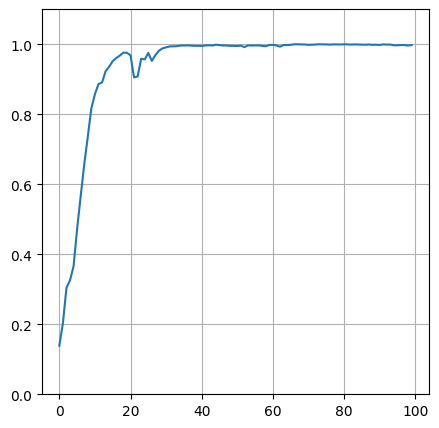

In [ ]:
xc = range(100)
plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(xc,history.history['accuracy'])


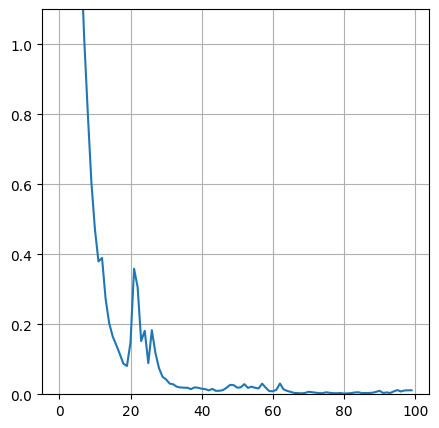

In [ ]:
xc = range(100)
plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(xc,history.history['loss'])


In [ ]:
X_test = X_test.reshape(-1, windowSize, windowSize, 30, 1)
X_test.shape

(7175, 25, 25, 30, 1)

In [ ]:
from keras.utils import to_categorical

# Assuming y_train contains integer labels
y_test = to_categorical(y_test)

# Check the shape after conversion
print(y_test.shape)


(7175, 16)


In [ ]:
Y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(y_test, axis=1), y_pred_test)
print(classification)

225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       1.00      0.99      0.99      1014
           2       0.99      0.99      0.99       577
           3       1.00      1.00      1.00       172
           4       1.00      0.99      1.00       359
           5       1.00      1.00      1.00       507
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00       344
           8       1.00      1.00      1.00        11
           9       0.99      1.00      0.99       686
          10       1.00      1.00      1.00      1695
          11       0.99      0.92      0.95       419
          12       0.95      1.00      0.98       143
          13       1.00      1.00      1.00       876
          14       1.00      0.99      1.00       265
          15       0.69      1.00      0.81        59

    accuracy                         

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(X_test,y_test,'IP')

225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.9921 - loss: 0.0448


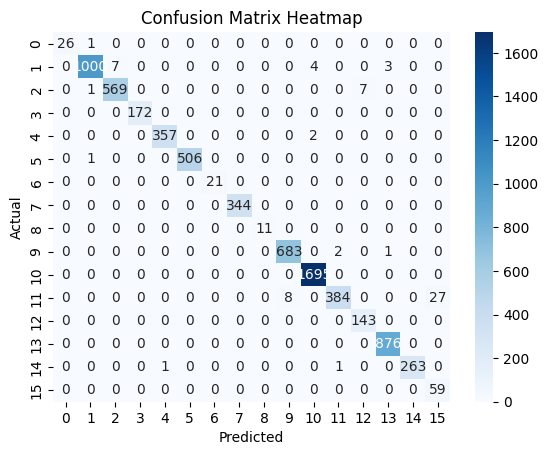

In [ ]:
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(X_test,y_test,'IP')
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"
file_name2 = "ground-truth-vs-predicted.img"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.9921 - loss: 0.0448


In [ ]:
import seaborn as sns


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
X = np.load("/content/indianpinearray.npy")
y = np.load("/content/IPgt.npy")

In [ ]:
X,pca = applyPCA(X, numComponents=30)

In [ ]:
X = padWithZeros(X, windowSize//2)

In [ ]:
PATCH_SIZE = windowSize
height = y.shape[0]
width = y.shape[1]
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

In [ ]:
!pip install spectral

import spectral


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 5.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



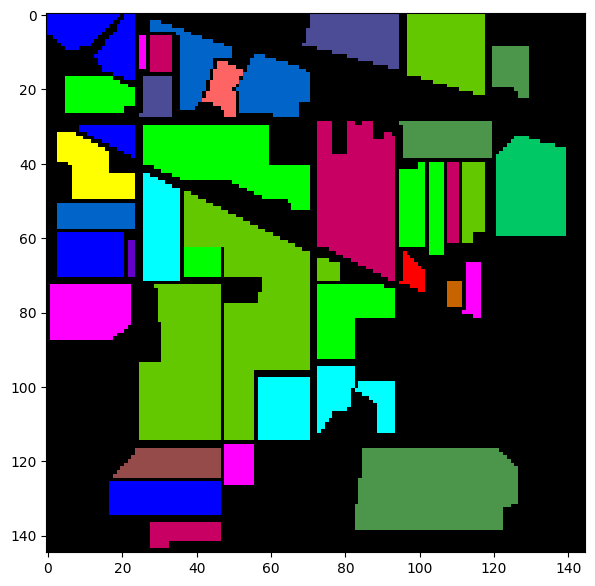

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

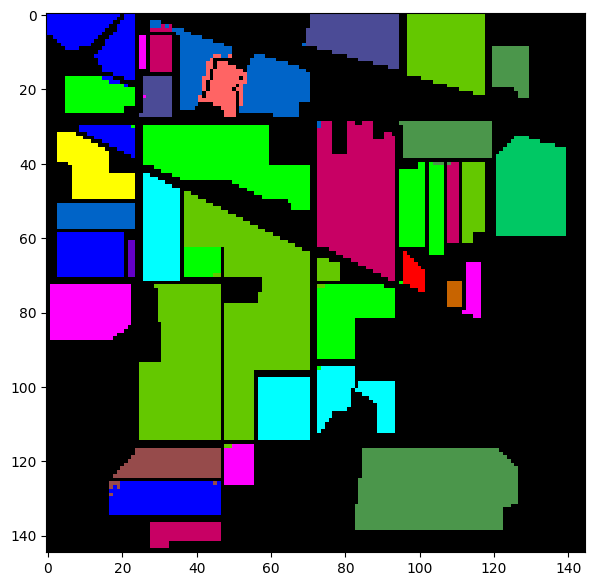

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))